In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Input, Dense, LSTM, Bidirectional, Dropout

In [2]:
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt

--2020-11-05 04:11:34--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.164.144, 172.253.122.128, 142.250.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.164.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘irish-lyrics-eof.txt’

irish-lyrics-eof.tx 100%[===================>]  67.35K  --.-KB/s    in 0.001s  

2020-11-05 04:11:34 (126 MB/s) - ‘irish-lyrics-eof.txt’ saved [68970/68970]



In [3]:
with open('/content/irish-lyrics-eof.txt', 'r') as f:
  data = f.read()
dataset = data.split('\n')

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(dataset)
print(tokenizer.word_index)

{'<OOV>': 1, 'the': 2, 'and': 3, 'i': 4, 'to': 5, 'a': 6, 'of': 7, 'my': 8, 'in': 9, 'me': 10, 'for': 11, 'you': 12, 'all': 13, 'was': 14, 'she': 15, 'that': 16, 'on': 17, 'with': 18, 'her': 19, 'but': 20, 'as': 21, 'when': 22, 'love': 23, 'is': 24, 'your': 25, 'it': 26, 'will': 27, 'from': 28, 'by': 29, 'they': 30, 'be': 31, 'are': 32, 'so': 33, 'he': 34, 'old': 35, 'no': 36, 'oh': 37, 'ill': 38, 'at': 39, 'one': 40, 'his': 41, 'there': 42, 'were': 43, 'heart': 44, 'down': 45, 'now': 46, 'we': 47, 'where': 48, 'young': 49, 'never': 50, 'go': 51, 'come': 52, 'then': 53, 'did': 54, 'not': 55, 'said': 56, 'away': 57, 'their': 58, 'sweet': 59, 'them': 60, 'green': 61, 'if': 62, 'take': 63, 'our': 64, 'like': 65, 'night': 66, 'day': 67, 'o': 68, 'out': 69, 'fair': 70, 'this': 71, 'town': 72, 'have': 73, 'can': 74, 'true': 75, 'its': 76, 'thou': 77, 'see': 78, 'dear': 79, 'more': 80, 'theres': 81, 'or': 82, 'had': 83, 'would': 84, 'over': 85, 'hear': 86, 'up': 87, 'ive': 88, 'through': 89, 

In [4]:
input_sequences = []
maxlen = max([len(s) for s in dataset])

for sentence in dataset:
  sequence = tokenizer.texts_to_sequences([sentence])[0]
  for n in range(2,len(sequence)+1):
    input_sequences.append(sequence[:n])

padded = pad_sequences(input_sequences, padding='pre', maxlen=maxlen)


X_data, y_data = padded[:, :-1], padded[:, -1]
print(X_data[0], y_data[0])

# test_ratio = 0.1
# train_size = int(len(X_data)*(1-test_ratio))

# X_train = X_data[:train_size]
# X_test = X_data[train_size:]

# y_train = y_data[:train_size]
# y_test = y_data[train_size:]


[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0 52] 13


In [5]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
EMBEDDING_DIMS = 64

class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.embedding = Embedding(VOCAB_SIZE, EMBEDDING_DIMS)
    self.lstm = Bidirectional(LSTM(128))
    self.do = Dropout(0.2)
    self.fc1 = Dense(256, activation='relu')
    self.fc2 = Dense(VOCAB_SIZE, activation='softmax')
  
  def call(self, x):
    x = self.embedding(x)
    x = self.lstm(x)
    x = self.do(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x
  
  def model(self):
    x = Input([None])
    return tf.keras.Model(inputs=[x], outputs=self.call(x))

In [6]:
model = MyModel()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.model().summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          172224    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               197632    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 2691)              691587    
Total params: 1,127,235
Trainable params: 1,127,235
Non-trainable params: 0
____________________________________________

In [7]:
epochs = 100
history = model.fit(X_data, y_data, epochs=epochs)

Epoch 1/100
377/377 [==============================] - 5s 13ms/step - loss: 6.6745 - accuracy: 0.0634
Epoch 2/100
377/377 [==============================] - 5s 13ms/step - loss: 6.2724 - accuracy: 0.0709
Epoch 3/100
377/377 [==============================] - 5s 13ms/step - loss: 6.0350 - accuracy: 0.0783
Epoch 4/100
377/377 [==============================] - 5s 13ms/step - loss: 5.8673 - accuracy: 0.0816
Epoch 5/100
377/377 [==============================] - 5s 12ms/step - loss: 5.6812 - accuracy: 0.0917
Epoch 6/100
377/377 [==============================] - 5s 13ms/step - loss: 5.4987 - accuracy: 0.1010
Epoch 7/100
377/377 [==============================] - 5s 13ms/step - loss: 5.3096 - accuracy: 0.1074
Epoch 8/100
377/377 [==============================] - 5s 13ms/step - loss: 5.1281 - accuracy: 0.1174
Epoch 9/100
377/377 [==============================] - 5s 13ms/step - loss: 4.9557 - accuracy: 0.1281
Epoch 10/100
377/377 [==============================] - 5s 12ms/step - loss: 4.782

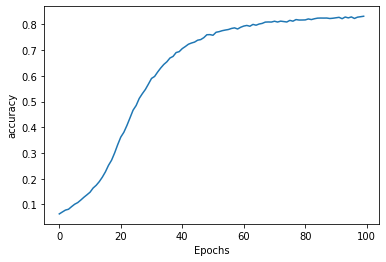

In [8]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

In [26]:
import numpy as np
tf.keras.backend.set_floatx('float64')

generate_num = 100
test_data = "I got a bad feeling about this"
test_sequence = tokenizer.texts_to_sequences([test_data])
test_sequence = pad_sequences(test_sequence, padding='pre', maxlen=maxlen)
for i in range(generate_num):
  z = np.zeros((test_sequence.shape[0], test_sequence.shape[1]+1))
  z[:,:-1] = test_sequence
  z[:, -1] = tf.argmax(model(test_sequence), axis=1).numpy()[0]
  test_sequence = z

print(f'Generate from "{test_data}" -> ', ' '.join(tokenizer.sequences_to_texts(test_sequence)[0].split()[-generate_num - len(test_data.split()):]))

Generate from "I got a bad feeling about this" ->  i got a bad feeling about this fathers rude and play the sea may be rough can be and sport and play the wild rover no hair in fray ye thee more and fair fell to the coolin her heart in my caubeen was hair and they took me rarely i did meet you all you have my thyme a peeping thru night it was painted married to the bower im in her lover do be he did lazy mans part part he and a pity and how they did be be lazy love part be agree agree agree agree agree run from their own be love
